# Lab 2 Modeling and Simulation of a Furuta Pendulum
#### This notebook contains code snippets to plot the data from the Furuta pendulum experiment, and to calculate the LQR gain vector for the double pendulum controller.

## Task 1 - Tune the dampening constants
#### We have gathered some data from a real furuta pendulum. The pendulum was dropped at an almost upright position and the resulting angles of the rotor and pendulum logged. Run the code below to load and plot the data.

Text(0, 0.5, 'radians')

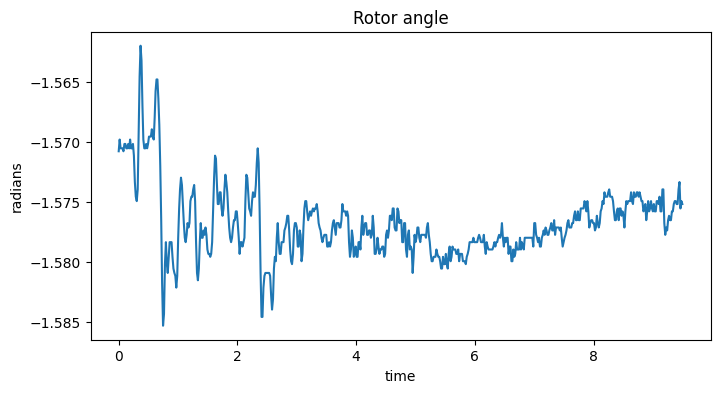

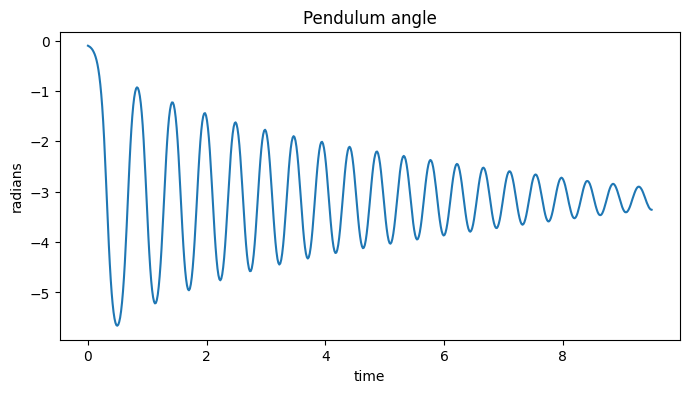

In [2]:
# Import Pandas and MatPlotLib
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]

# Import the data from google drive using Pandas
furuta_data = pd.read_csv('https://drive.google.com/uc?export=dowload&id=1h_f8h-EVbuwfANGVZn-6tRICi-tEaMli')

plt.figure(1)
plt.clf()
plt.plot(furuta_data.t, furuta_data.rotorPhi)
plt.title("Rotor angle")
plt.xlabel("time")
plt.ylabel("radians")

plt.figure(2)
plt.clf()
plt.plot(furuta_data.t, furuta_data.pendulumPhi)
plt.title("Pendulum angle")
plt.xlabel("time")
plt.ylabel("radians")

## Task 3 - Calculate the LQR gain vector
#### Create the linear state space model for the double pendulum, linearized around the downward position of the two pendulum arms

In [ ]:
import numpy as np
import scipy.linalg

# Initialize constants
J = 125e-06
l1 = 0.075
l2 = 0.030
m1 = l1*np.pi*0.0025*0.0025*3700
m2 = l2*np.pi*0.0025*0.0025*3700
r = 0.043
g = 9.82

# Parameter declaration
a1 = J + m1*r*r
b1 = 1/3 * m1*l1*l1
c1 = 1/2 * m1*r*l1
d1 = 1/2 * m1*g*l1

a2 = J + m2*r*r
b2 = 1/3 * m2*l2*l2
c2 = 1/2 * m2*r*l2
d2 = 1/2 * m2*g*l2

# State Space declaration
A = np.zeros((6,6))
A[0,1] = 1
A[1,2] = -(d1*c1)/(a1*b1 - c1**2)
A[1,4] = -(d2*c2)/(a2*b2 - c2**2)
A[2,3] = 1
A[3,2] = -(a1*d1)/(a1*b1 - c1**2)
A[4,5] = 1
A[5,4] = -(a2*d2)/(a2*b2 - c2**2)

B = np.zeros((6,1))
B[1,0] = b1/(a1*b1 - c1**2) + b2/(a2*b2 - c2**2)
B[3,0] = c1/(a1*b1 - c1**2)
B[5,0] = c2/(a2*b2 - c2**2)

In [1]:
import numpy as np
import scipy.linalg

# ---- constants (SI) ----
J  = 125e-6
l1 = 0.075
l2 = 0.030
r  = 0.043
g  = 9.82
rho = 3700      # density (kg/m^3)
d   = 0.005     # diameter 5 mm → radius 2.5 mm
m1 = l1*np.pi*(d/2)**2 * rho
m2 = l2*np.pi*(d/2)**2 * rho

# ---- parameters ----
a1 = J + m1*r*r
b1 = (1/3)*m1*l1*l1
c1 = 0.5*m1*r*l1
d1 = 0.5*m1*g*l1

a2 = J + m2*r*r
b2 = (1/3)*m2*l2*l2
c2 = 0.5*m2*r*l2
d2 = 0.5*m2*g*l2

# ---- state-space ----
A = np.zeros((6,6))
A[0,1] = 1
A[1,2] = -(d1*c1)/(a1*b1 - c1**2)
A[1,4] = -(d2*c2)/(a2*b2 - c2**2)
A[2,3] = 1
A[3,2] = -(a1*d1)/(a1*b1 - c1**2)
A[4,5] = 1
A[5,4] = -(a2*d2)/(a2*b2 - c2**2)

B = np.zeros((6,1))
B[1,0] = b1/(a1*b1 - c1**2) + b2/(a2*b2 - c2**2)
B[3,0] = c1/(a1*b1 - c1**2)
B[5,0] = c2/(a2*b2 - c2**2)

# # ---- LQR weights (先用保守起步，可之后调整) ----
# Q = np.diag([10.0, 0.1, 40.0, 0.5, 40.0, 0.5])
# R = np.array([[1e-2]])   # R 越大 → 力矩越保守/更稳，反之更激进
Q = np.diag([5.0, 0.2, 20.0, 0.5, 20.0, 0.5])  # 更平滑
R = np.array([[0.05]])   # R 大一点，让控制“温柔”一点

# ---- CARE ----
P = scipy.linalg.solve_continuous_are(A, B, Q, R)
K = np.linalg.solve(R, B.T @ P)     # shape (1,6)
print("K =", K)


K = [[ 31.6227766    6.67564666  77.18956359   5.81902114 170.26476984
   -0.32515368]]


In [3]:
print(np.linalg.eigvals(A - B@K))

[-1.38996494e+05 +0.j         -9.79427273e+00 +0.j
 -5.79491049e+00+10.2974075j  -5.79491049e+00-10.2974075j
 -3.42595996e+00+15.87338315j -3.42595996e+00-15.87338315j]


#### Using the defined cost matrices, calculate the LQR gain by solving the continuous-time algebraic Riccati equation

In [ ]:
# Define the cost matrices
Q = np.zeros((6,6))
Q[0,0] = 1
Q[1,1] = 1e-3
Q[2,2] = 1
Q[3,3] = 1e-3
Q[4,4] = 1
Q[5,5] = 1e-3

R = np.zeros((1,1))
R[0,0] = 1e-4

# Solve the continuous-time algebraic Riccati equation
P = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))

# Calculate the LQR gain
K = scipy.linalg.solve(R, B.T*P)

print(K)